In [1]:
from libraries import *
from utils import *
%matplotlib inline

##### Reading manually cleaned folders

In [44]:
from scipy.misc import imread
from scipy.linalg import norm
from scipy import sum, sqrt, mean, std, average

In [2]:
i_otrain = '../../datasets/helen/output/trainset/preprocessed_labels'
i_ctrain = '../../datasets/helen/output/trainset/clean'
i_dtrain = '../../datasets/helen/output/deleted'

# setting paths again
i_po = i_otrain # input path origial
i_pc = i_ctrain # input path clean
i_pd = i_dtrain # input path deleted

i_formats = ['*.jpg', '*.JPG', '*.png']

i_pol = reduce(operator.add, [glob(os.path.join(i_po, i)) for i in i_formats], [])
i_pcl = reduce(operator.add, [glob(os.path.join(i_pc, i)) for i in i_formats], [])
i_pdl = reduce(operator.add, [glob(os.path.join(i_pd, i)) for i in i_formats], [])

print('Total: %d  |  Clean:  %d  |  Deleted: %d' %(len(i_pol), len(i_pcl), len(i_pdl)))

cl = [i.split('/')[-1].split('.')[0].split('_cb')[0] for i in i_pcl]
dl = [i.split('/')[-1].split('.')[0].split('_cb')[0] for i in i_pdl]

print('Clean:  %d  |  Deleted: %d' %(len(cl), len(dl)))

Total: 2000  |  Clean:  912  |  Deleted: 1088
Clean:  912  |  Deleted: 1088


#### OPTION 1: Distance between image iso and mirror image iso
##### [SKIP] Apply 'cleaning' to original and mirrored isomaps dir: 'helen_mirrored_iso'

In [ ]:
def euclidean(x, y):
    return np.sqrt(np.sum((x - y)**2))
              
def manhattan(x, y):
    return np.sum(abs(x - y))
              
def KL(x, y):
    eps = 0.0000001
    return np.sum((x + eps) * np.log((x + eps) / (y + eps)))

def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3: return average(arr, -1)  # average over the last axis (color channels)
    else: return arr

def minkowski(x, y, nroot=2):
    def nth_root(x, n_root): return x ** (1/float(n_root))
    return nth_root(np.sum(abs(x - y) ** nroot), nroot)

def ncc(x, y): 
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / ((x.size - 1) * np.std(x) * np.std(y))
 
def cosine(x, y):
    def square_rooted(x): return np.sqrt(np.sum([a*a for a in x]))
    num = np.sum(x * y)
    den = np.sqrt(np.sum(x ** 2)) * np.sqrt(np.sum(y ** 2))
    return num/den
 
def cosine_(x, y):
    import scipy
    return scipy.spatial.distance.cosine(x, y, w=None)
 
def jaccard(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality / union_cardinality

def norm(x, y): return np.linalg.norm(x - y)

def hamming(x, y):
    assert len(s1) == len(s2)
    return np.sum(x != y)# for c1, c2 in zip(s1, s2))

In [67]:
g_p = '../../datasets/helen_mirrored_iso'
cd = 'trainset_clean'
dd = 'trainset_deleted'
o_pc = os.path.join(g_p, cd)
o_pd = os.path.join(g_p, dd)

for i in [o_pc, o_pd]: 
    if not os.path.exists(i): os.makedirs(i)
    else: print('Warning: "%s" folder already exists: adding files..' %i)

i_p = os.path.join(g_p, 'trainset') # input path original

sample_size = None
i_ext = ['*.jpg', '*.JPG', '*.png']

i_pl = reduce(operator.add, [glob(os.path.join(i_p, i)) for i in i_ext], [])

if not sample_size: sample_size = len(i_pl)
print('Total available images: %d' %len(i_pl))

i_pcl_m, i_pdl_m = [], []

for i in i_pl[:sample_size]:
    f_name = i.split('/')[-1].split('.')[0]
    if f_name.split('_')[-1] == 'mirror': continue
    
    f_name_m = f_name + '_mirror'   
    if len(glob(os.path.join(i_p, f_name_m + '.isomap.png'))) == 0: 
        print('Not mirror .iso found for %s' %i)
        continue
    
    i_m = os.path.join(i_p, f_name_m + '.isomap.png')
    
    if f_name in cl: 
        os.system('cp %s %s %s' %(i, i_m, o_pc))
        i_pcl_m.append((i, i_m)) 
    elif f_name in dl: 
        os.system('cp %s %s %s' %(i, i_m, o_pd))
        i_pdl_m.append((i, i_m))
    else: os.system('cp %s %s %s' %(i, i_m, os.path.join(g_p, 'rest')))

print('Clean:  %d  |  Deleted: %d' %(len(glob(os.path.join(o_pc, '*'))), len(glob(os.path.join(o_pd, '*')))))
print('Clean:  %d  |  Deleted: %d' %(len(i_pcl_m), len(i_pdl_m)))

Total available images: 3932
Clean:  1780  |  Deleted: 2084
Clean:  890  |  Deleted: 1042


#### OPTION 1: Distance between image iso and mirror image iso

In [ ]:
# g_p = '../../datasets/helen_mirrored_iso'
# cd = 'trainset_clean'
# dd = 'trainset_deleted'
# i_pc = os.path.join(g_p, cd)
# i_pd = os.path.join(g_p, dd)

# i_ext = ['*.jpg', '*.JPG', '*.png']

# i_pcl = reduce(operator.add, [glob(os.path.join(i_pc, i)) for i in i_ext], [])
# i_pdl = reduce(operator.add, [glob(os.path.join(i_pd, i)) for i in i_ext], [])

In [229]:
gray = True

print('Total: %d  |  Clean:  %d  |  Deleted: %d' %(len(i_pcl_m) + len(i_pdl_m), len(i_pcl_m), len(i_pdl_m)))

lss = {'euclidean': euclidean, 'manhattan': manhattan, 'KL': KL, 'minkowski': minkowski, \
       'cosine': cosine, 'ncc': ncc, 'hamming': hamming}
sets = {'clean': i_pcl_m, 'deleted': i_pdl_m}

distances = {i: {'paths': [], 'losses': {j: [] for j in lss.keys()}} for i in sets.keys()}
print(distances)

for s in sets.keys():
    for i in sets[s]:
        distances[s]['paths'] = i
        im = cv2.imread(i[0], cv2.IMREAD_UNCHANGED)
        im_m = cv2.imread(i[1], cv2.IMREAD_UNCHANGED)
#         print(im.shape, im_m.shape)
        if grey: im, im_m = to_grayscale(im), to_grayscale(im_m)
#         print(im.shape, im_m.shape)
        for l in lss.keys():
            distances[s]['losses'][l].append(lss[l](im, im_m))

print('Clean:  %d  |  Deleted: %d' %(len(distances['clean']['paths']), len(distances['deleted']['paths'])))

Total: 1932  |  Clean:  890  |  Deleted: 1042
{'deleted': {'paths': [], 'losses': {'minkowski': [], 'KL': [], 'euclidean': [], 'cosine': [], 'hamming': [], 'ncc': [], 'manhattan': []}}, 'clean': {'paths': [], 'losses': {'minkowski': [], 'KL': [], 'euclidean': [], 'cosine': [], 'hamming': [], 'ncc': [], 'manhattan': []}}}
deleted
clean
Clean:  2  |  Deleted: 2


##### Visualizing 

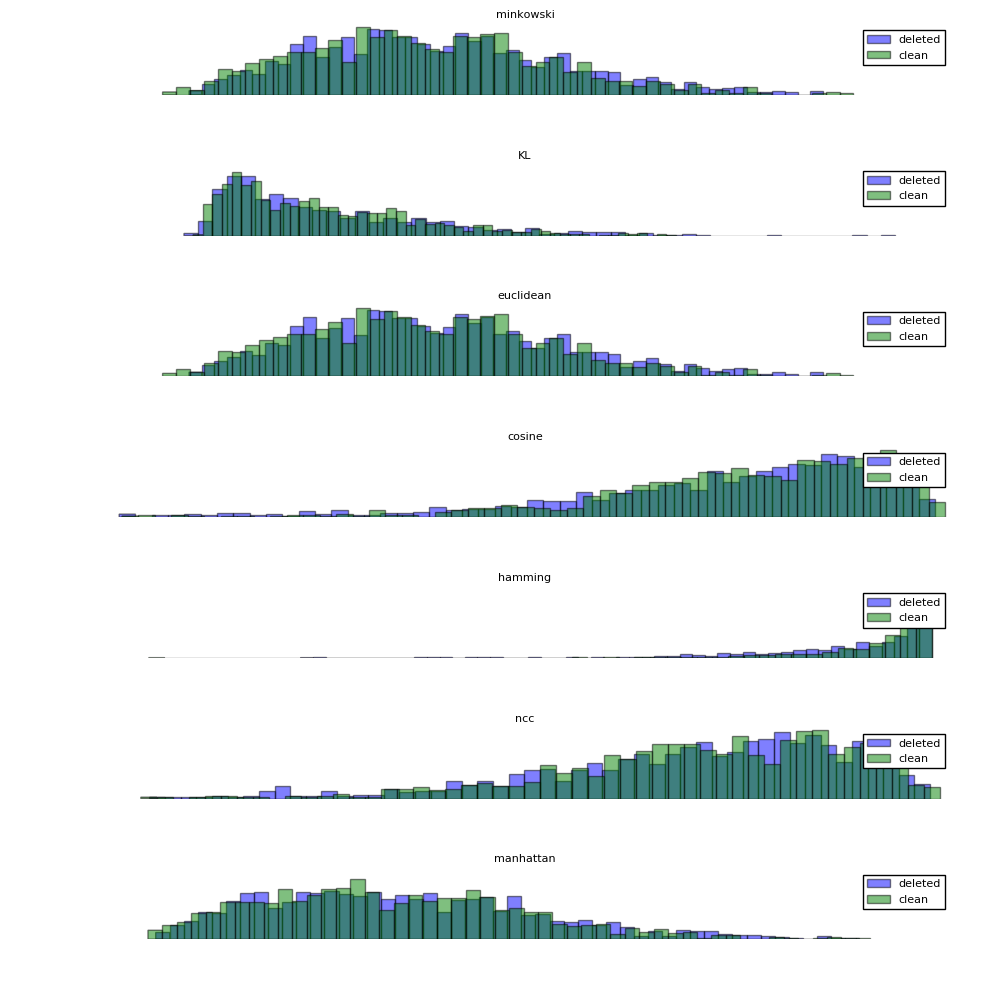

In [230]:
fw = 10

data = distances
n_series = len(distances.items())
n_plots = len(distances[distances.keys()[0]]['losses'])

f, a = plt.subplots(n_plots, 1, figsize=(fw, fw)) #len(losses[losses.keys()[0]]), figsize=(6, 3))
a = a.ravel()
for _, ax in enumerate(a):
    loss = lss.keys()[_] #; print(loss)
#     serie = data.keys()[_]
    ax.set_title(loss, fontsize=8)
    for s in data.keys():
        ax.hist(data[s]['losses'][loss], bins=50, alpha=0.5, label=s, normed=True) #, edgecolor='none')
    ax.set_xlabel('value', fontsize=8)
    ax.set_ylabel('volume', fontsize=8)
    ax.legend(loc='upper right', fontsize=8) #, edgecolor='white') #draw_frame = False)
    ax.axis('off')

# st = fig.suptitle("suptitle", fontsize="x-large")
# plt.suptitle('cleaning process distributions', fontsize = 10)
plt.tight_layout()
# leg = legend()
# leg.get_frame().set_alpha(0) # this will make the box totally transparent
# leg.get_frame().set_edgecolor(‘white’) # make the edges of the border white to match the background
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.legend.html?highlight=matplotlib%20pyplot%20legend#matplotlib.pyplot.legend

('minkowski', 'ncc')


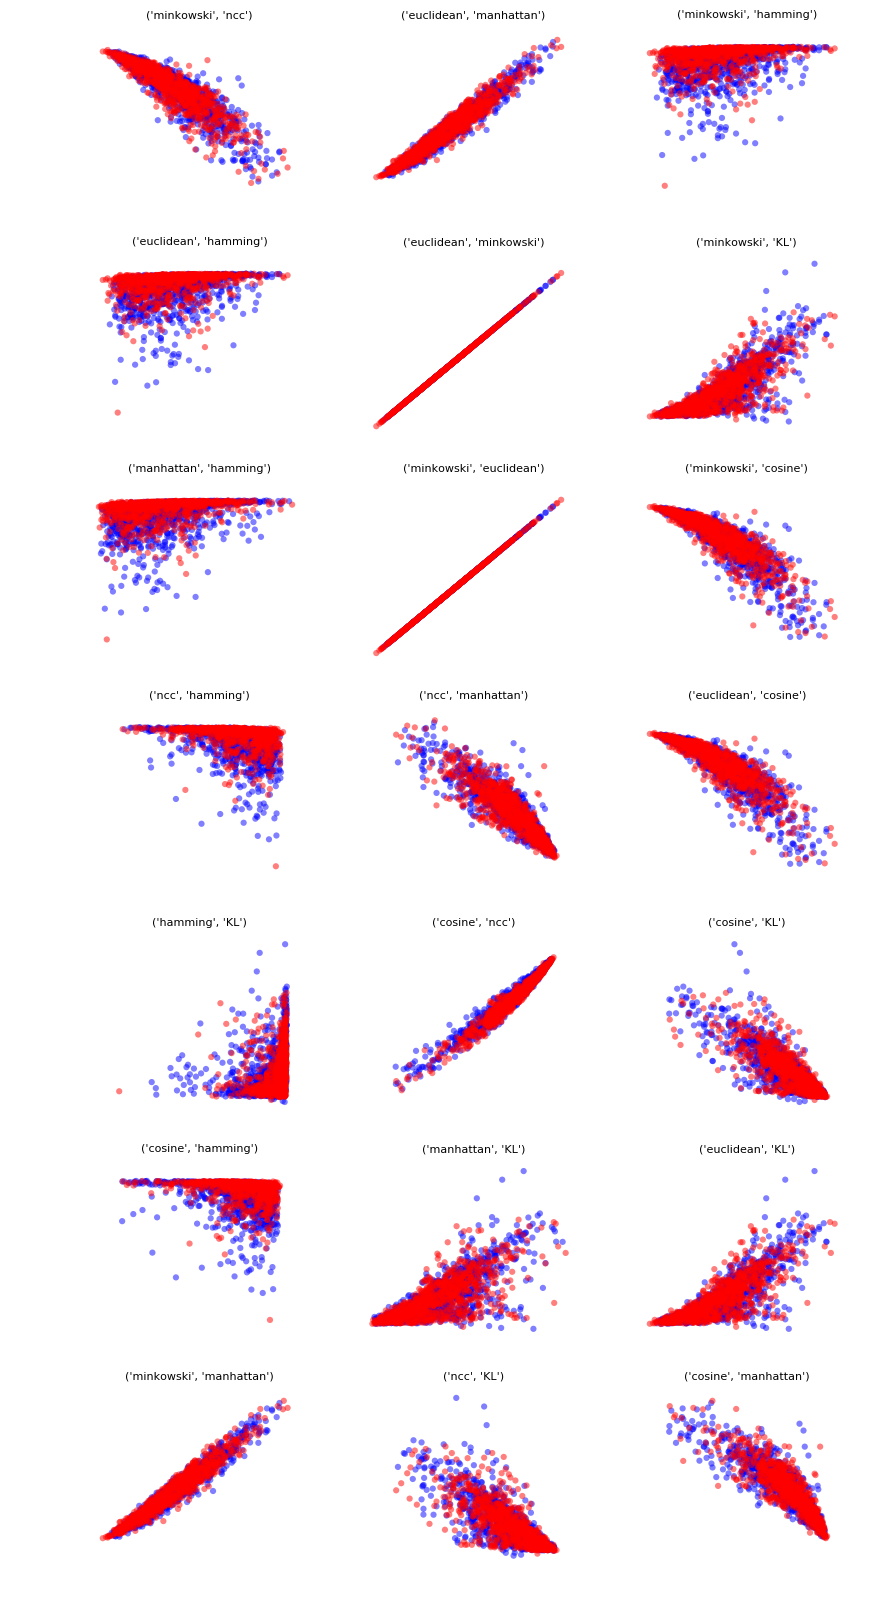

In [231]:
l = [{i, j} for i in lss.keys() for j in lss.keys() if i != j]
comb = list({tuple(i) for i in l})
print(comb[0])

fw = 10
colorl=['b', 'r']
data = distances
n_series = len(distances.items())
n_plots = len(comb)
nppr = 3
n_rows = int(n_plots / nppr)

f, a = plt.subplots(n_rows, nppr, figsize=(fw, fw*2)) #len(losses[losses.keys()[0]]), figsize=(6, 3))
a = a.ravel()
for _, ax in enumerate(a):
    loss_pair = comb[_]
    ax.set_title(loss_pair, fontsize=8)
    for _, s in enumerate(data.keys()):
        ax.scatter(data[s]['losses'][loss_pair[0]], 
                   data[s]['losses'][loss_pair[1]], 
                   alpha=0.5, label=s, color=colorl[_], edgecolors='none')

    ax.set_xlabel('value', fontsize=8)
    ax.set_ylabel('volume', fontsize=8)
#     ax.legend(loc='upper right', fontsize=8) #, edgecolor='white') #draw_frame = False)
    ax.axis('off')

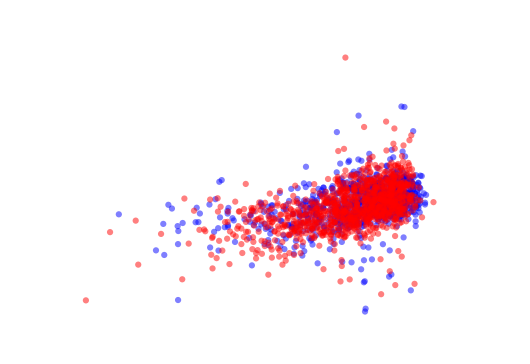

In [187]:
s1 = distances['clean']['losses']
s2 = distances['deleted']['losses']

plt.scatter(s1['euclidean'], s1['manhattan'], alpha=0.5, edgecolors='none')
plt.scatter(s2['euclidean'], s2['manhattan'], alpha=0.5, color='r', edgecolors='none')
plt.axis('off')
plt.show()

# N = 50
# x = np.random.rand(N)
# y = np.random.rand(N)
# colors = np.random.rand(N)
# area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

# plt.scatter(x, y, s=area, c=colors, alpha=0.5, edgecolors='none')
# plt.show()

In [2]:
#### JUMP HERE

#### setting lists of paths & instersection between datasets -"deleted" folder

In [ ]:
i_otrain = '../../datasets/helen/output/trainset/preprocessed_labels'
# i_otest = '../../datasets/helen/output/testset/preprocessed_labels'
i_ctrain = '../../datasets/helen/output/trainset/clean'
# i_ctest = '../../datasets/helen/output/clean'

o_p = '../../datasets/helen/output/'

In [8]:
i_po = i_otrain # input path origial
i_pc = i_ctrain # input path clean

sample_size = None

# gather not cleaned images

i_formats = ['*.jpg', '*.JPG', '*.png']

o_pd = os.path.join(o_p, 'deleted') # output path deleted
if not os.path.exists(o_pd): os.makedirs(o_pd)
else: print('Warning: "%s" folder already exists: adding files..' %o_pd)

i_pol = reduce(operator.add, [glob(os.path.join(i_po, i)) for i in i_formats], [])
i_pcl = reduce(operator.add, [glob(os.path.join(i_pc, i)) for i in i_formats], [])

if not sample_size: sample_size = len(i_pol)
print('Total available images: %d' %len(i_pol))

i_pdl = []

# for i in i_pol[:sample_size]:
#     f_name = i.split('/')[-1].split('.')[0]
#     if len(glob(os.path.join(i_pc, f_name + '*'))) == 0: i_pdl.append(os.path.join(i_pc, f_name + '*'))
    
for i in i_pol[:sample_size]:
    f_name = i.split('/')[-1].split('.')[0]
    if len(glob(os.path.join(i_pc, f_name + '*.jpg'))) == 0:
        i_pdl.append(os.path.join(o_pd, f_name + '.png'))
        im = cv2.imread(i, cv2.IMREAD_UNCHANGED)
#         print(i)
#         cv2.imwrite(os.path.join(o_pd, f_name + '.png'), im)
        os.system('cp %s %s' %(i, o_pd))
#     for j in i_pcl: 
#         print(f_name, j)
#         if f_name not in j: i_pdl.append(i)
# i_pdl = [i for i in i_pol[:sample_size] if any(i.split('/')[-1].split('.')[0]iscontained in j for j in i_pcl)]    

print(len(i_pol), len(i_pcl), len(i_pdl))

Total available images: 2000
(2000, 912, 1088)


## HERE
#### simmetry losses given paths

In [147]:
from scipy.misc import imread
from scipy.linalg import norm
from scipy import sum, sqrt, mean, std, average

def euclidean(x, y):
    return np.sqrt(np.sum((x - y)**2))
              
def manhattan(x, y):
    return np.sum(abs(x - y))
              
def KL(x, y):
    eps = 0.0000001
    return np.sum((x + eps) * np.log((x + eps) / (y + eps)))

def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3: return average(arr, -1)  # average over the last axis (color channels)
    else: return arr

def nth_root(x, n_root):
    return x ** (1/float(n_root))
 
def minkowski(x, y, nroot):
    return nth_root(np.sum(abs(x - y) ** nroot), nroot)

def ncc(x, y): 
    return np.sum((x - np.mean(x)) * (y - np.mean(y))) / ((x.size - 1) * np.std(x) * np.std(y))



In [139]:
def euclidean_(x, y):
    return sqrt(sum((x - y)^2)) / x.size
              
def manhattan_(x, y):
    return sum(abs(x - y)) / x.size

def ncc_(x, y): 
    return sum((x - mean(x)) * (y - mean(y))) / ((x.size - 1) * std(x) * std(y))

from math import *
from decimal import Decimal
 
def nth_root(value, n_root):
 
    root_value = 1/float(n_root)
    return round (Decimal(value) ** Decimal(root_value),3)
 
def minkowski_(x,y,p_value):
 
    return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),p_value)

def square_rooted(x):
 
    return round(sqrt(sum([a*a for a in x])),3)
 
def cosine_similarity(x,y):
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = square_rooted(x)*square_rooted(y)
    return round(numerator/float(denominator),3)
 
print cosine_similarity([3, 45, 7, 2], [2, 54, 13, 15])

 
def jaccard_similarity(x,y):
 
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
 
print jaccard_similarity([0,1,2,5,6],[0,2,3,5,7,9])

In [150]:
n = '2868155068_1_cb.png'
p = '2957533922_1_cb.jpg'

i_p = '../../datasets/helen/output/trainset/clean'
i_n = '../../datasets/helen/output/deleted'

i = p6
p = os.path.join(i_p, i)
x, y = read(p)

print(euclidean(x, y), euclidean_(x, y))
print(manhattan(x, y), manhattan_(x, y))
print(ncc(x, y))

x.size


Processing file: ../../datasets/helen/output/trainset/clean/2957533922_1_cb.jpg
(4606.1018225827356, 0.016191101162097512)
(40388584, 102.71348063151042)
0.922103408703


393216

In [140]:
i_otrain = '../../datasets/helen/output/trainset/preprocessed_labels'
i_ctrain = '../../datasets/helen/output/trainset/clean'
i_dtrain = '../../datasets/helen/output/deleted'

# setting paths again
i_po = i_otrain # input path origial
i_pc = i_ctrain # input path clean
i_pd = i_dtrain # input path deleted

i_formats = ['*.jpg', '*.JPG', '*.png']

i_pol = reduce(operator.add, [glob(os.path.join(i_po, i)) for i in i_formats], [])
i_pcl = reduce(operator.add, [glob(os.path.join(i_pc, i)) for i in i_formats], [])
i_pdl = reduce(operator.add, [glob(os.path.join(i_pd, i)) for i in i_formats], [])

print('Total: %d  |  Clean:  %d  |  Deleted: %d' %(len(i_pol), len(i_pcl), len(i_pdl)))

# ls = ['euclidean', 'manhattan', 'KL']
# # losses['euclidean'] = {'o': deu_o, 'c': deu_c, 'd': deu_d}

deu_o, deu_c, deu_d = [], [], []
dma_o, dma_c, dma_d = [], [], []
dkl_o, dkl_c, dkl_d = [], [], []

# sets = {'clean': i_pcl, 'deleted': i_pdl}
# losses = ['euclidean', 'manhattan', 'KL']
# options = ['color', 'grey']
# # im = to_grayscale(im)
# dist = []

# # original datasets
# for i, j in sets.items():
#     print('Adding %s dataset..' %s)
#     # iterating over the dataset
#     for k in j:
#         f_name = i.split('/')[-1].split('.')[0]
#         im = cv2.imread(i)
        
#         h1 = im[:im.shape[0], :int(im.shape[1]/2), :]
#         h2 = im[:im.shape[0], int(im.shape[1]/2):, :]
#         # flip h2
#         h2f = np.fliplr(h2)

#         # distances 
#         for l in ls:
#             losses[l] = deu_o, deu_c, deu_d = [], [], []
#             x, y = h1, h2f
#             deu_o.append(eu)
#             dma_o.append(ma)

# clean dataset
for i in i_pcl:
    f_name = i.split('/')[-1].split('.')[0]

    im = cv2.imread(i)
    h1 = im[:im.shape[0], :int(im.shape[1]/2), :]
    h2 = im[:im.shape[0], int(im.shape[1]/2):, :]
    # flip h2
    h2f = np.fliplr(h2)
    
    x, y = h1, h2f
    eu = np.sqrt(np.sum((x - y)**2))
    ma = np.sum(abs(x - y))
    kl = KL(x, y)
    
    deu_c.append(eu)
    dma_c.append(ma)
    dkl_c.append(kl)

# deleted dataset
for i in i_pdl:
    f_name = i.split('/')[-1].split('.')[0]

    im = cv2.imread(i)
    h1 = im[:im.shape[0], :int(im.shape[1]/2), :]
    h2 = im[:im.shape[0], int(im.shape[1]/2):, :]
    # flip h2
    h2f = np.fliplr(h2)
    
    x, y = h1, h2f
    eu = np.sqrt(np.sum((x - y)**2))
    ma = np.sum(abs(x - y)) 
    kl = KL(x, y)
    
    deu_d.append(eu)
    dma_d.append(ma)
    dkl_d.append(kl)
    
print(len(deu_o), len(deu_c), len(deu_d))
print(len(dma_o), len(dma_c), len(dma_d))
print(len(dkl_o), len(dkl_c), len(dkl_d))

Total: 2000  |  Clean:  912  |  Deleted: 1088
(0, 912, 1088)
(0, 912, 1088)
(0, 912, 1088)


In [141]:
print(np.mean(deu_o), np.mean(deu_c), np.mean(deu_d))
print(np.mean(dma_o), np.mean(dma_c), np.mean(dma_d))

print(np.std(deu_o), np.std(deu_c), np.std(deu_d))
print(np.std(dma_o), np.std(dma_c), np.std(dma_d))

print(min(deu_o), min(deu_c), min(deu_d))
print(max(deu_o), max(deu_c), max(deu_d))

print(min(dma_o), min(dma_c), min(dma_d))
print(max(dma_o), max(dma_c), max(dma_d))

(nan, 5287.3131366737543, 5318.4568911132101)
(nan, 43671659.916666664, 43038031.853860296)
(nan, 394.08384596667867, 363.92013726123946)
(nan, 11431841.734466473, 11328040.196578467)


ValueError: min() arg is an empty sequence

In [ ]:
# plot_im(h2f); print(h2f.shape)

In [ ]:
len(data['o'])
data.keys
len(losses.keys())

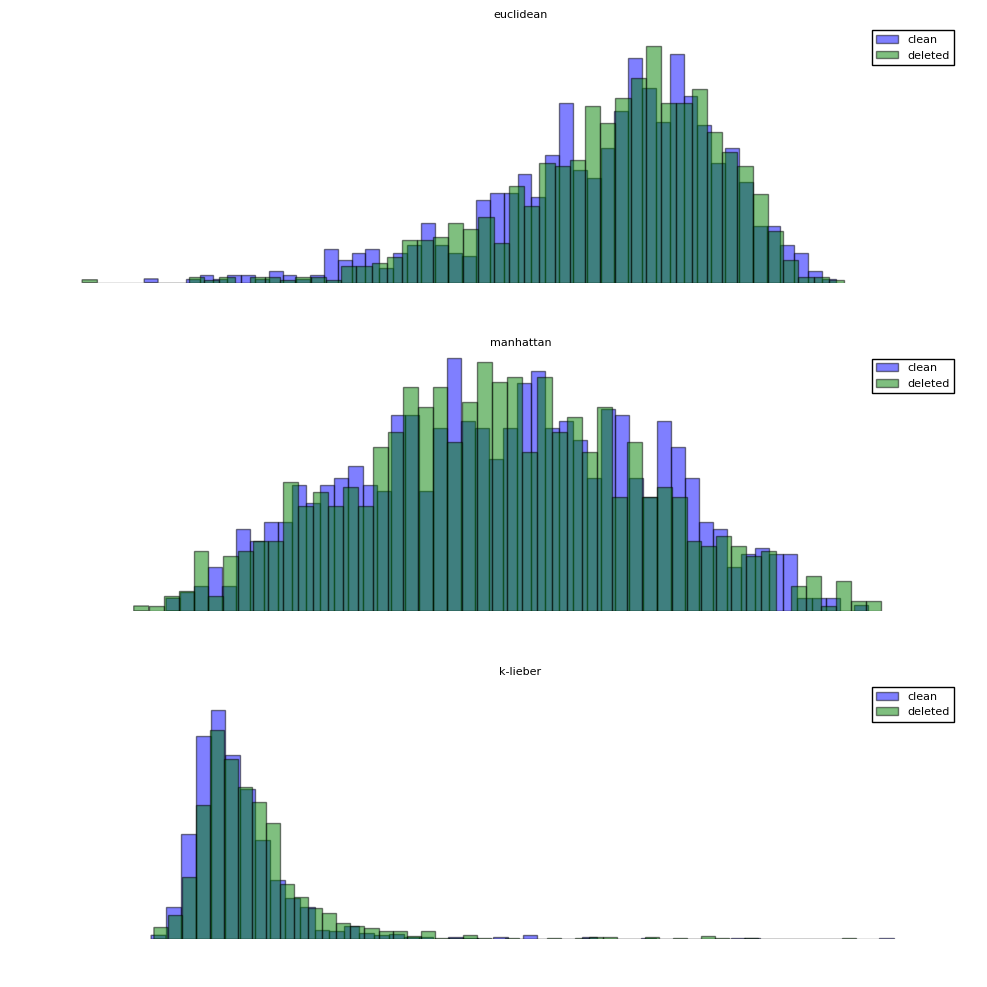

In [143]:
losses = {}
losses['euclidean'] = {'o': deu_o, 'c': deu_c, 'd': deu_d}
losses['manhattan'] = {'o': dma_o, 'c': dma_c, 'd': dma_d}
losses['k-lieber'] = {'o': dkl_o, 'c': dkl_c, 'd': dkl_d}

# plotting
fw = 10

f, a = plt.subplots(len(losses.keys()), 1, figsize=(fw, fw)) #len(losses[losses.keys()[0]]), figsize=(6, 3))
a = a.ravel()
for _, ax in enumerate(a):
    l = losses.keys()[_]
    data = losses[l]
    ax.set_title(l, fontsize=8)
    for i in ['clean', 'deleted']:
        ax.hist(data[i[0]], bins=50, alpha=0.5, label=i, normed=True)
    ax.set_xlabel('value', fontsize=8)
    ax.set_ylabel('volume', fontsize=8)
    ax.legend(loc='upper right', fontsize=8)
    ax.axis('off')

# st = fig.suptitle("suptitle", fontsize="x-large")
# plt.suptitle('cleaning process distributions', fontsize = 10)
plt.tight_layout()

## Simmetry Losses for the HELEN train dataset

In [4]:
i_otrain = '../../datasets/helen/output/trainset/preprocessed_labels'
i_ctrain = '../../datasets/helen/output/trainset/clean'
i_dtrain = '../../datasets/helen/output/deleted'

# setting paths again
i_po = i_otrain # input path origial
i_pc = i_ctrain # input path clean
i_pd = i_dtrain # input path deleted

sample_size = None

i_formats = ['*.jpg', '*.JPG', '*.png']

i_pol = reduce(operator.add, [glob(os.path.join(i_po, i)) for i in i_formats], [])
i_pcl = reduce(operator.add, [glob(os.path.join(i_pc, i)) for i in i_formats], [])
i_pdl = reduce(operator.add, [glob(os.path.join(i_pd, i)) for i in i_formats], [])

print('Total: %d  |  Clean:  %d  |  Deleted: %d' %(len(i_pol), len(i_pcl), len(i_pdl)))

Total: 2000  |  Clean:  912  |  Deleted: 1088


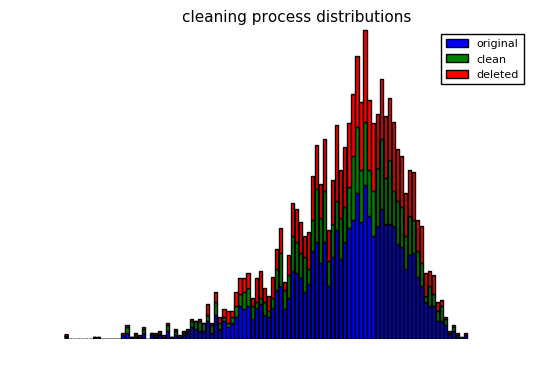

In [24]:
sets = [i_pol, i_pcl, i_pdl] 

sim_lss = {}

# ol = {}
# cl = {}
# dl = {}

for i in sets:
    sim_lss[i] = []
    for j in i: 
        """
        for each image: p: path; eu: euclidean, ma: manhattan, co: cosine, kl: KL divergence
        """
        
        f_name = i.split('/')[-1].split('.')[0]
        print('Processing file: %s' %i)
        
        # read image
        im = cv2.imread(i)
        h1 = im[:im.shape[0], :int(im.shape[1]/2), :]
        h2 = im[:im.shape[0], int(im.shape[1]/2):, :]
        h2_flipped = np.fliplr(h2)
        
        # simmetry losses 
        x, y = h1, h2f
        eu = np.sqrt(np.sum((x - y)**2)) ; deuc_d.append(euc)
        ma = np.sum(abs(x - y)) ; dman_d.append(man)
        kl = 
        co = 
        
        # compering with scipy losses
        
        
        # storing
        d = {'p': p, 'eu': eu, 'ma': ma, 'kl': , 'co': co}
        sim_lss[i].append(d)
        
# create dataframe, select columns
df1x = dman_o
df2x = dman_c
df3x = dman_d

#Stack the data
plt.figure()
plt.hist([df1x, df2x, df3x], bins=100, stacked=True)
plt.title('cleaning process distributions', fontsize=11)
plt.xlabel('value', fontsize=11)
plt.ylabel('volume', fontsize=11)
plt.legend(['original', 'clean', 'deleted'], fontsize=8)
plt.axis('off')
plt.show()

In [142]:
## START SMALL

def read(i):
    f_name = i.split('/')[-1].split('.')[0]
    print('\nProcessing file: %s' %i)

    # read image
    im = cv2.imread(p)
    h1 = im[:im.shape[0], :int(im.shape[1]/2), :]
    h2 = im[:im.shape[0], int(im.shape[1]/2):, :]
    h2_flipped = np.fliplr(h2)
    return h1, h2_flipped

# NUMPY

def main_numpy(x, y):
    eu = np.sqrt(np.sum((x - y)**2))
    ma = np.sum(abs(x - y))
    kl = KL(x, y)
    print('numpy: ' , eu, ma, kl)
    

#     # Should be normalized though
#     values1 = np.asarray([1.346112,1.337432,1.246655])
#     values2 = np.asarray([1.033836,1.082015,1.117323])

#     # Note slight difference in the final result compared to Dawny33
#     print KL(values1, values2) # 0.775278939433
    

# SCIPY
from scipy.misc import imread
from scipy.linalg import norm
from scipy import sum, sqrt, mean, std, average

def main_scipy(x, y):
    file1, file2 = x, y
    # read images as 2D arrays (convert to grayscale for simplicity)
#     img1 = to_grayscale(imread(file1).astype(float))
#     img2 = to_grayscale(imread(file2).astype(float))
    img1 = to_grayscale(x)
    img2 = to_grayscale(y)
    # compare
    n_m, n_0 = compare_images(img1, img2)
    print('scipy1:')
    print("Manhattan norm:", n_m, "/ per pixel:", n_m/img1.size)
    print("Zero norm:", n_0, "/ per pixel:", n_0*1.0/img1.size)
    
    i1, i2 = x, y
    d_euc = sqrt(sum((i1 - i2)^2)) / i1.size
    d_man = sum(abs(i1 - i2)) / i1.size
    d_ncc = sum((i1 - mean(i1)) * (i2 - mean(i2))) / ((i1.size - 1) * std(i1) * std(i2))
    print('scipy2: ', d_euc, d_man, d_ncc)
    
def compare_images(img1, img2):
    # normalize to compensate for exposure difference
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = sum(abs(diff))  # Manhattan norm
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    return (m_norm, z_norm)

def to_grayscale(arr):
    "If arr is a color image (3D array), convert it to grayscale (2D array)."
    if len(arr.shape) == 3:
        return average(arr, -1)  # average over the last axis (color channels)
    else:
        return arr

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng

# MAIN

# positives
p1 = '112117768_1_cb.jpg' # in the verge
p2 = '129408727_1_cb.jpg' # in the verge
p3 = '130625688_1_cb.jpg' # in the verge
p4 = '129594949_1_cb.jpg'
p5 = '130361594_1_cb.jpg'
p6 = '2957533922_1_cb.jpg'

# negatives
n1 = '2744427984_1_cb.png' # in the verge
n2 = '2743945084_1_cb.png' # in the verge
n3 = '2782810504_1_cb.png' # in the verge
n4 = '2756003523_1_cb.png' # critical - good simmetry
# n5 = '244222195369_1_cb.png'
n5 = '2748918408_1_cb.png'
n6 = '2753825731_1_cb.png'
n7 = '2756860536_1_cb.png'

p = [p1, p2, p3, p4, p5]
n = [n1, n2, n3, n4, n5, n6, n7]

# main
    
i_p = '../../datasets/helen/output/trainset/clean'
i_n = '../../datasets/helen/output/deleted'

# print("\nPositives")
# for i in p:
#     p = os.path.join(i_p, i)
#     x, y = read(p)
#     print(x.shape, x[x.shape[0]/2, x.shape[1]/2, 0], x.dtype)
#     main_numpy(x, y)
#     main_scipy(x, y)
# #     main_pil(x, y)

# print("\nNegatives")
# for i in n:
#     p = os.path.join(i_n, i)
#     x, y = read(p)
#     main_numpy(x, y)
#     main_scipy(x, y)
# #     main_pil(x, y)

i = p6
p = os.path.join(i_p, i)
x, y = read(p)

print(euclidean(x, y), manhattan(x, y), minkowski(x, y, 3))


Processing file: ../../datasets/helen/output/trainset/clean/2957533922_1_cb.jpg


TypeError: Cannot convert 36594682 to Decimal

#### Option 2: compare original and flipped image isomaps

In [7]:
i_p = '/'

sample_size = 10

lps = glob(os.path.join(i_p, "*.png"))

ops = []
mps = []

for i in lps:
    f_name = i.split('/')[-1].split('.')[0]
    
    if f_name.split('_')[-1] != 'mirror': 
        op = i
        mp = i.split('.isomap.png')[0] + '_mirror.isomap.png'
#         print(op, mp)
        if len(glob(mp)) == 0: 
            print("No mirror detected")
            continue
        else: 
            ops.append(op)
            mps.append(mp)

print(len(ops), len(mps))

dts = []
for i, j in zip(ops, mps):
    im_o = cv2.imread(i)
    im_m = cv2.imread(j)

    dist = np.linalg.norm(im_o-im_m)
    dts.append(dist)
    
print(len(dts))

# from scipy.spatial import distance
# a = (1,2,3)
# b = (4,5,6)
# dst = distance.euclidean(a,b)

# def dist(x,y):   
#     return numpy.sqrt(numpy.sum((x-y)**2))

# a = numpy.array((xa,ya,za))
# b = numpy.array((xb,yb,zb))
# dist_a_b = dist(a,b)


# import numpy as np
# import matplotlib as plt
# a = np.array([1,2,3])
# b = np.array([2,3,4])
# # distance between a and b
# dis = plt.mlab.dist(a,b)

# distance = np.sqrt(np.sum((a-b)**2))

# from math import sqrt
# a = (1,2,3) #data point 1
# b = (4,5,6) #data point 2
# print (sqrt(sum((a - b)**2 for a, b in zip(im_o, im_m))))

68 68
68


In [13]:
import matplotlib
import numpy
import perfplot
from scipy.spatial import distance


def linalg_norm(data):
    a, b = data
    return numpy.linalg.norm(a-b, axis=1)


def sqrt_sum(data):
    a, b = data
    return numpy.sqrt(numpy.sum((a-b)**2, axis=1))


def scipy_distance(data):
    a, b = data
    return map(distance.euclidean, a, b)


def mpl_dist(data):
    a, b = data
    return map(matplotlib.mlab.dist, a, b)


def sqrt_einsum(data):
    a, b = data
    return numpy.einsum('ij,ij->i', a-b, a-b)**0.5


perfplot.show(
    setup=lambda n: numpy.random.rand(2, n, 3),
    n_range=[2**k for k in range(15)],
    kernels=[linalg_norm, scipy_distance, mpl_dist, sqrt_sum, sqrt_einsum],
    logx=True,
    logy=True,
#     xlabel='len(x), len(y)'
    )

  0%|          | 0/5 [00:00<?, ?it/s]



TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [14]:
from math import*
from decimal import Decimal
 
class Similarity():
 
    """ Five similarity measures function """
 
    def euclidean_distance(self,x,y):
 
        """ return euclidean distance between two lists """
 
        return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
 
    def manhattan_distance(self,x,y):
 
        """ return manhattan distance between two lists """
 
        return sum(abs(a-b) for a,b in zip(x,y))
 
    def minkowski_distance(self,x,y,p_value):
 
        """ return minkowski distance between two lists """
 
        return self.nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(x, y)),
           p_value)
 
    def nth_root(self,value, n_root):
 
        """ returns the n_root of an value """
 
        root_value = 1/float(n_root)
        return round (Decimal(value) ** Decimal(root_value),3)
 
    def cosine_similarity(self,x,y):
 
        """ return cosine similarity between two lists """
 
        numerator = sum(a*b for a,b in zip(x,y))
        denominator = self.square_rooted(x)*self.square_rooted(y)
        return round(numerator/float(denominator),3)
 
    def square_rooted(self,x):
 
        """ return 3 rounded square rooted value """
 
        return round(sqrt(sum([a*a for a in x])),3)
 
    def jaccard_similarity(self,x,y):
#     """ returns the jaccard similarity between two lists """
        intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
        union_cardinality = len(set.union(*[set(x), set(y)]))
        return intersection_cardinality/float(union_cardinality)

    
from similaritymeasures import Similarity
 
def main():
 
    """ the main function to create Similarity class instance and get used to it """
 
    measures = Similarity()
 
    print measures.euclidean_distance([0,3,4,5],[7,6,3,-1])
    print measures.jaccard_similarity([0,1,2,5,6],[0,2,3,5,7,9])
 
if __name__ == "__main__":
    main()

In [16]:
# !jupyter nbconvert --to script dp_mask_contour_and_fill_missing_data.ipynb

In [ ]:
#### H_stack

# ips = glob(os.path.join(i_p, '*_fmd.png'))
# lps = glob(os.path.join(l_p, '*_cb.png'))

# ops = []
# mps = []

# ils = np.empty((0,) + (512, 2*512, 4))
# for i in ips:
#     f_name = i.split('/')[-1].split('_fmd.png')[0]
#     if f_name.split('_')[-1] == 'mirror': continue
    
#     # detect label data
#     if len(glob(os.path.join(l_p, f_name + '*_cb.png'))) == 0:
#         print('No label detected for file %s' %f_name)
#         continue

#     print('Processing file: %s' %i)
#     im = cv2.imread(i, cv2.IMREAD_UNCHANGED)
#     lb = cv2.imread(os.path.join(l_p, f_name + '_cb.png'), cv2.IMREAD_UNCHANGED)
#     il = np.hstack((im, lb))
#     ils = np.append(ils, il.reshape((1,) + il.shape), axis=0)
# #   rebuild with hsplit

# plot_im(ils[0][:,:,:3])